In [481]:
import pandas as pd
import numpy as np
import os
from zipfile import ZipFile
from datetime import datetime
import seaborn as sns
import matplotlib.pylab as plt
from scipy import stats

### Data import

In [482]:
# Zip-file import
zip_file = ZipFile('datasets.zip')

# Making a dictionary with all dfs in the zip-file
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

# Making an empty df
df = pd.DataFrame(columns=['sale_time', 'purchaser_gender'])

# Concatenating all dfs to the one df that will be used in the data analysis
for csv in dfs:
    df = pd.concat([df, dfs[csv]])

In [483]:
# Let's have a look to the combined df
df.head()

,sale_time,purchaser_gender
0,2012-10-15 01:22:12,male
1,2012-10-15 01:26:36,male
2,2012-10-15 01:40:15,female
3,2012-10-15 01:55:55,female
4,2012-10-15 02:00:33,female


In [484]:
df.dtypes

sale_time           object
purchaser_gender    object
dtype: object

In [485]:
# Change sale_time to datetime data type
df['sale_time'] = pd.to_datetime(df['sale_time'])

In [486]:
# Checking datatypes
df.dtypes

sale_time           datetime64[ns]
purchaser_gender            object
dtype: object

In [487]:
# Also let's take a week number from the date and year in order to group by weeks by year
df['year'] = df['sale_time'].dt.isocalendar().year
df['week_num'] = df['sale_time'].dt.isocalendar().week
df['month'] = df['sale_time'].dt.month
df['day'] = df['sale_time'].dt.day
df = df.astype({'year': 'int32', 'week_num': 'int32', 'month': 'int32', 'day': 'int32'})

In [488]:
df.head()

,sale_time,purchaser_gender,year,week_num,month,day
0,2012-10-15 01:22:12,male,2012,42,10,15
1,2012-10-15 01:26:36,male,2012,42,10,15
2,2012-10-15 01:40:15,female,2012,42,10,15
3,2012-10-15 01:55:55,female,2012,42,10,15
4,2012-10-15 02:00:33,female,2012,42,10,15


### 1. Plot daily sales for all 50 weeks

In [489]:
sales_by_weeks = df.groupby(['year', 'week_num'], as_index=False) \
                   .sale_time.count() \
                   .rename(columns={'sale_time': 'sales_amount'})

In [490]:
# Let's take a look at our dataframe
sales_by_weeks.head()

,year,week_num,sales_amount
0,2012,40,3545
1,2012,41,3440
2,2012,42,3451
3,2012,43,3463
4,2012,44,3696


Text(0.5, 0, 'Week number')

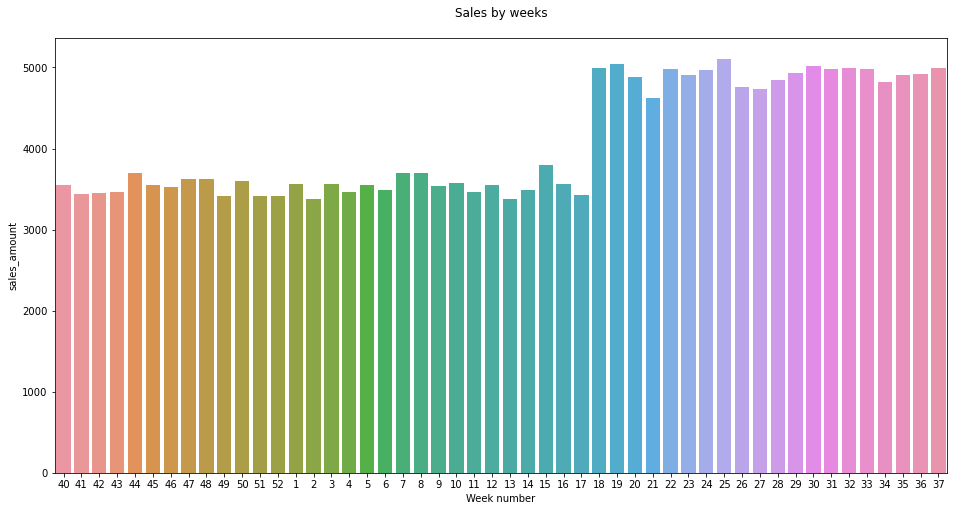

In [491]:
# And plot it!
plt.figure(figsize=(16,8))
plt.title('Sales by weeks\n')

sns.barplot(data=sales_by_weeks,
            x='week_num',
            y='sales_amount',
            order=sales_by_weeks['week_num'])

# plt.locator_params(axis='x', nbins=25)
plt.xlabel("Week number")

### 2. It looks like there has been a sudden change in daily sales. What date did it occur?

In [492]:
# let's look at those two weeks where the biggest change occured
change_17_18 = df.query('week_num == [17, 18]').groupby(['year', 'week_num', 'month', 'day'], as_index=False) \
    .sale_time.count() \
    .sort_values(['month', 'day'])
change_17_18

,year,week_num,month,day,sale_time
0,2013,17,4,22,540
1,2013,17,4,23,472
2,2013,17,4,24,487
3,2013,17,4,25,498
4,2013,17,4,26,480
5,2013,17,4,27,489
6,2013,17,4,28,458
7,2013,18,4,29,732
8,2013,18,4,30,732
9,2013,18,5,1,709


In [493]:
# Count the difference in order to find the biggest change
change_17_18['abs_change'] = change_17_18['sale_time'].diff().apply(abs)

In [494]:
max_diff = change_17_18.sort_values('abs_change', ascending=False).head(1)

print(f'Date of the biggest change: {max_diff.iloc[0, 3]}-{max_diff.iloc[0, 2]}-{max_diff.iloc[0, 0]} (max abs diff: {max_diff.iloc[0, 5]})')

Date of the biggest change: 29-4-2013 (max abs diff: 274.0)


### 3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?

In [495]:
df['date'] = df['sale_time'].dt.date

In [496]:
sales_per_day = df.groupby('date', as_index=False) \
    .sale_time.count()
sales_per_day.head()

,date,sale_time
0,2012-10-01,514
1,2012-10-02,482
2,2012-10-03,499
3,2012-10-04,546
4,2012-10-05,476


In [497]:
#count diff for the whole dataset
sales_per_day['diff'] = sales_per_day['sale_time'].diff().apply(abs)

In [498]:
#then count the p-value for our max change in order to see the p-value
print(f'P-value: {stats.ttest_1samp(sales_per_day["diff"].dropna(), sales_per_day["diff"].max())[1]}')

P-value: 3.8957725020358616e-290


### 4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).

In [499]:
# In order to see the proportion - we should group our data by date and gender
gender_count = df.groupby(['date', 'purchaser_gender'], as_index=False) \
                    .sale_time.count() \
                    .pivot(index='date', columns='purchaser_gender', values='sale_time').reset_index()

gender_count

purchaser_gender,date,female,male
0,2012-10-01,413,101
1,2012-10-02,379,103
2,2012-10-03,386,113
3,2012-10-04,432,114
4,2012-10-05,368,108
...,...,...,...
345,2013-09-11,224,495
346,2013-09-12,225,510
347,2013-09-13,206,537
348,2013-09-14,193,462


In [500]:
# Then we make another column which will show us th edifference between females and males customers
gender_count['female_male_ratio'] = gender_count['female'] / gender_count['male']
gender_count['all_purchases'] = gender_count['female'] + gender_count['male']

<AxesSubplot:xlabel='date', ylabel='all_purchases'>

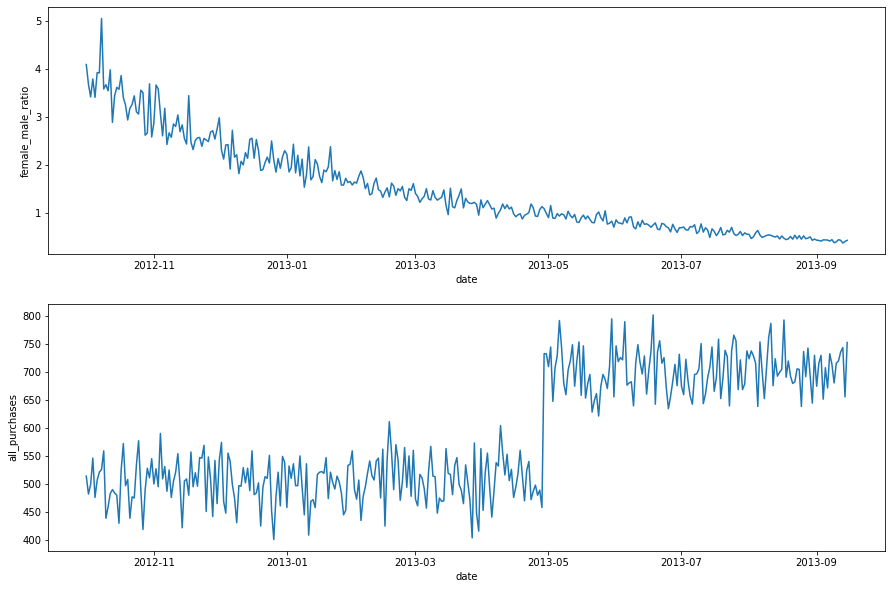

In [501]:
# And plot it!
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.lineplot(data=gender_count,
             x='date', y='female_male_ratio',
             ax=ax[0])
sns.lineplot(data=gender_count,
             x='date', y='all_purchases',
             ax=ax[1])

We see on the graph that first dates characterised by the bigger amount of female customers, than the situation changed simmetrically.  
What we also that there is no such big change in the female/male ratio, that we see on the overall purchases graph

### 5. Assume a given day is divided into four dayparts:
#### - night (12:00AM - 6:00AM),
#### - morning (6:00AM - 12:00PM),
#### - afternoon (12:00PM - 6:00PM),
#### - evening (6:00PM - 12:00AM).
#### What is the percentage of sales in each daypart over all 50 weeks?

In [502]:
df['hour'] = df.sale_time.dt.hour

In [503]:
df.head()

,sale_time,purchaser_gender,year,week_num,month,day,date,hour
0,2012-10-15 01:22:12,male,2012,42,10,15,2012-10-15,1
1,2012-10-15 01:26:36,male,2012,42,10,15,2012-10-15,1
2,2012-10-15 01:40:15,female,2012,42,10,15,2012-10-15,1
3,2012-10-15 01:55:55,female,2012,42,10,15,2012-10-15,1
4,2012-10-15 02:00:33,female,2012,42,10,15,2012-10-15,2


In [504]:
def time_bins(x):
    if x < 6:
        return 'night'
    elif x >= 6 and x < 12:
        return 'morning'
    elif x >= 12 and x < 18:
        return 'afternoon'
    else:
        return 'evening'

In [505]:
df['day_period'] = df['hour'].apply(time_bins)

In [506]:
df.head()

,sale_time,purchaser_gender,year,week_num,month,day,date,hour,day_period
0,2012-10-15 01:22:12,male,2012,42,10,15,2012-10-15,1,night
1,2012-10-15 01:26:36,male,2012,42,10,15,2012-10-15,1,night
2,2012-10-15 01:40:15,female,2012,42,10,15,2012-10-15,1,night
3,2012-10-15 01:55:55,female,2012,42,10,15,2012-10-15,1,night
4,2012-10-15 02:00:33,female,2012,42,10,15,2012-10-15,2,night


In [507]:
df['day_period'].value_counts(normalize=True)

afternoon    0.394134
morning      0.307690
evening      0.208585
night        0.089591
Name: day_period, dtype: float64